In [1]:
"""复现结果
    加权平均 稳定度
"""
## -*- coding:utf-8 -*-

##数据读入  

import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#写入数据列名称   设置字段类型      
col_file = pd.read_csv("colname.csv", sep=',', header=None, index_col=None) #118个特征
allcol_list=[]
numcol_list=[]
catcol_list=[]
usecol_list=[]

model_col = []

for i in range(len(col_file)):
    allcol_list.append(col_file[0][i])
    if col_file[1][i]!='none' and col_file[1][i]!='flag': #num cat
        usecol_list.append(col_file[0][i])
    if col_file[1][i]=='num':
        numcol_list.append(col_file[0][i])
    if col_file[1][i]=='cat':
        catcol_list.append(col_file[0][i])
        
#读取数据  
alldata = pd.read_csv("train_test", sep=',', names=allcol_list ,index_col=None)
s=alldata.copy()
alldata.describe()
print('数据读取完成')

数据读取完成


C:\Users\wkb\AppData\Local\Temp\ipykernel_2100\300222764.py:37: DtypeWarning: Columns (115,116) have mixed types. Specify dtype option on import or set low_memory=False.
  alldata = pd.read_csv("train_test", sep=',', names=allcol_list ,index_col=None)


In [2]:
#字段类型设置   

#缺失值用零填充 
alldata = alldata.replace({'\\N': np.nan})
alldata = alldata.fillna(value=0)

#cat编码序列化 
for i in catcol_list:
    alldata[i] = alldata[i].astype('category')
    alldata[i] = alldata[i].cat.codes

In [3]:
def draw_features(model, title=''):
    feature_importance_array = model.feature_importances_
    # imp_df={}
    # for i in range(len(usecol_list)):
    #     imp_df[usecol_list[i]]=feature_importance_array[i]
    df=pd.DataFrame(feature_importance_array,index=[usecol_list])
    df_dis=df.sort_values(by=0,ascending=False).head(20)

    rc = {'font.sans-serif': 'SimHei',
        'axes.unicode_minus': False}
    sns.set(font_scale=0.9,rc=rc)

    plt.bar(x = range(len(df_dis)), # 指定条形图x轴的刻度值
            height = df_dis[0], # 指定条形图y轴的数值
            tick_label = df_dis.index, # 指定条形图x轴的刻度标签
            color = 'steelblue', # 指定条形图的填充色
            width = 0.8, 
            )
    plt.title(title + '重要变量')
    plt.xticks(rotation=90)
    plt.show()

In [4]:
import pickle

def train_model(model_num=1):
    model_name = ['', '离网模型', '携转模型', '降档模型']
    X=alldata[(alldata['flag']==0)|(alldata['flag']==model_num)][usecol_list]
    Y=alldata[(alldata['flag']==0)|(alldata['flag']==model_num)]['flag']
    #切分训练集
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
    #模型训练gbdt
    model = GradientBoostingClassifier(learning_rate=0.4, 
                                       n_estimators=50, 
                                       subsample=0.75,
                                       max_depth=3, 
                                       max_features='log2',
                                       random_state=49
                                       )
    model.fit(X_train, y_train)

    ###保存模型到文件       

    with open('model/model_' + str(model_num) + '.pkl', 'wb') as file:
        pickle.dump(model, file)
        
        ##预测
    y_predict = model.predict(X_test)
    # y_predict_proba = model.predict_proba(X_test)
    # y_test_score = model.decision_function(X_test)

    # y_train_predict = model.predict(X_train)

    ##模型训练结果  分析   
    # print(classification_report(y_train, y_train_predict))
    # print(confusion_matrix(y_train, y_train_predict))

    print(classification_report(y_test, y_predict))
    # print("test AUC is ", roc_auc_score(y_test, y_predict))
    print(confusion_matrix(y_test, y_predict))
    draw_features(model, model_name[model_num])

* 选取模型特征和标志 1离网模型-lw  2携转模型-xz  3降档模型-jd 
* 上述三种模型flag取值分别为1, 2, 3以及正常0
* 此处选择离网和正常作为正例和负例，其余同理

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1843
           1       0.67      0.53      0.59       401

    accuracy                           0.87      2244
   macro avg       0.78      0.74      0.76      2244
weighted avg       0.86      0.87      0.86      2244

[[1737  106]
 [ 189  212]]


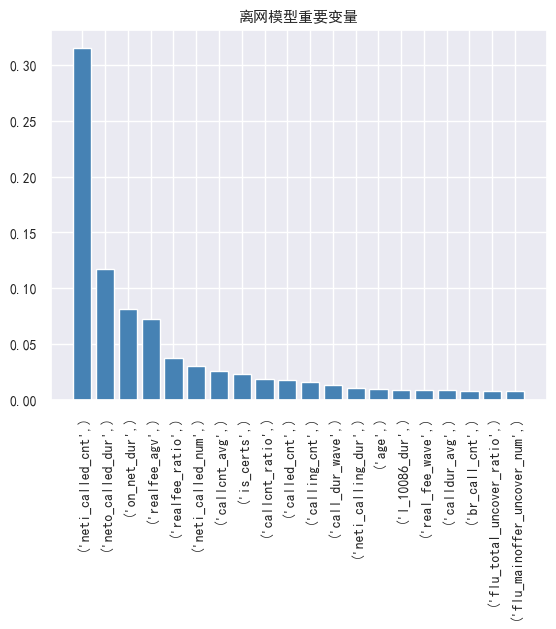

In [6]:
# 离网模型
train_model(1)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1831
           2       0.38      0.18      0.25       121

    accuracy                           0.93      1952
   macro avg       0.66      0.58      0.60      1952
weighted avg       0.91      0.93      0.92      1952

[[1795   36]
 [  99   22]]


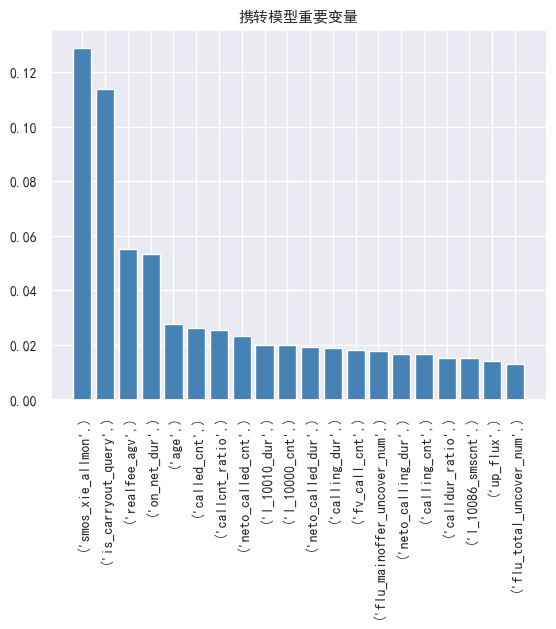

In [7]:
# 携转模型
train_model(2)

              precision    recall  f1-score   support

           0       0.78      0.75      0.77      1821
           3       0.66      0.69      0.67      1255

    accuracy                           0.73      3076
   macro avg       0.72      0.72      0.72      3076
weighted avg       0.73      0.73      0.73      3076

[[1370  451]
 [ 389  866]]


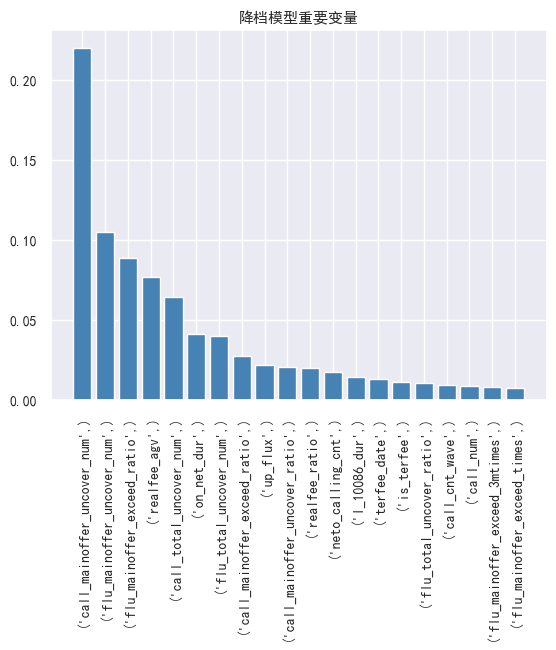

In [8]:
# 降档模型
train_model(3)

In [9]:
## -*- coding:utf-8 -*-

##模型保存的结果上   预测阶段代码    修改读取方式    文件过大 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys


#写入数据列名称   设置字段类型      
col_file = pd.read_csv("colname-pre.csv", sep=',', header=None, index_col=None)
allcol_list=[]
numcol_list=[]
catcol_list=[]
usecol_list=[]

for i in range(len(col_file)):
    allcol_list.append(col_file[0][i])
    if col_file[1][i]!='none' and col_file[1][i]!='flag':
        usecol_list.append(col_file[0][i])
    if col_file[1][i]=='num':
        numcol_list.append(col_file[0][i])
    if col_file[1][i]=='cat':
        catcol_list.append(col_file[0][i])
        
##模型读取  1离网模型  2携转模型  3降档模型 

with open('model//model_1.pkl', 'rb') as file:
    model_1 = pickle.load(file)

with open('model//model_2.pkl', 'rb') as file:
    model_2 = pickle.load(file)

with open('model//model_3.pkl', 'rb') as file:
    model_3 = pickle.load(file)

In [10]:
#读取数据 
all = pd.read_csv("pre_test", sep=',', names=allcol_list, header=None,index_col=False, chunksize=1000000)
for chunk in all:
    s=chunk.copy()
    alldata=chunk
#     alldata.describe()
#     print(chunk)
    print('数据读取完成')

###缺失值用零填充 
alldata = alldata.replace({'\\N': np.nan})
alldata = alldata.fillna(value=0)

 #cat编码序列化   
for i in catcol_list:
    alldata[i] = alldata[i].astype('category')
    alldata[i] = alldata[i].cat.codes

数据读取完成


In [11]:
##预测   输出三个子模型的得分   
X=alldata[usecol_list]

y_predict_proba_1 = pd.Series(model_1.predict_proba(alldata[usecol_list])[:,1].tolist(),index=alldata.index)

y_predict_proba_2 = pd.Series(model_2.predict_proba(alldata[usecol_list])[:,1].tolist(),index=alldata.index)

y_predict_proba_3 = pd.Series(model_3.predict_proba(alldata[usecol_list])[:,1].tolist(),index=alldata.index)

# 每个模型中重要性前五的列
imp_list_1 = ['realfee_agv','called_cnt','on_net_dur','call_cnt','neti_called_cnt']   
imp_list_2 = ['is_carryout_query','smos_xie_allmon','called_num','realfee_agv','neto_called_cnt']                
imp_list_3 = ['flu_mainoffer_uncover_times','call_mainoffer_uncover_num','realfee_agv','flu_total_uncover_num','call_total_uncover_times']       

s['realfee_agv']=s['realfee_agv']/100

result_data = pd.concat([s['subs_id'],y_predict_proba_1,s[imp_list_1],y_predict_proba_2,s[imp_list_2],y_predict_proba_3,s[imp_list_3]],axis=1)
result_data.rename(columns={0:'proba_1',1:'proba_2',2:'proba_3'},inplace=True)  
result_data.head()

,subs_id,proba_1,realfee_agv,called_cnt,on_net_dur,call_cnt,neti_called_cnt,proba_2,is_carryout_query,smos_xie_allmon,called_num,realfee_agv,neto_called_cnt,proba_3,flu_mainoffer_uncover_times,call_mainoffer_uncover_num,realfee_agv,flu_total_uncover_num,call_total_uncover_times
0,**,0.737005,32.3933,59,255,80,35,0.775741,8,0,26,32.3933,24,0.478396,9.9740,0,32.3933,0.9974,74
1,**,0.913437,57.0000,34,256,45,16,0.927865,8,0,20,57.0000,17,0.533552,19.9962,0,57.0000,0.9998,488
2,**,0.767374,60.0667,98,273,155,80,0.995724,38,0,28,60.0667,18,0.354710,8.7150,0,60.0667,0.8715,93
3,**,0.608024,43.0667,41,271,67,20,0.998278,8,0,26,43.0667,21,0.344056,9310.8923,0,43.0667,0.9992,32
4,**,0.795370,190.8200,270,271,504,193,0.994282,58,0,75,190.8200,77,0.308813,68.5721,0,190.8200,0.9796,723


In [12]:
###稳定度综合得分计算 
#1 降档模型分档字段设计
#2 汇总生成 稳定度综合得分   
#分档位值处理       

s = s.replace({'\\N': np.nan})
s = s.fillna(value=0)
fav_list=s['fav_val'].copy().astype('float')

fav_list[(fav_list>=0  ) & (fav_list<=8 )]=1.0  
fav_list[(fav_list>8   ) & (fav_list<18 )]=0.280
fav_list[(fav_list>=18 ) & (fav_list<20 )]=0.555
fav_list[(fav_list>=20 ) & (fav_list<28 )]=0.588
fav_list[(fav_list>=28 ) & (fav_list<38 )]=0.687
fav_list[(fav_list>=38 ) & (fav_list<48 )]=0.650
fav_list[(fav_list>=48 ) & (fav_list<50 )]=0.528
fav_list[(fav_list>=50 ) & (fav_list<58 )]=0.569
fav_list[(fav_list>=58 ) & (fav_list<68 )]=0.651
fav_list[(fav_list>=68 ) & (fav_list<78 )]=0.356
fav_list[(fav_list>=78 ) & (fav_list<88 )]=0.472
fav_list[(fav_list>=88 ) & (fav_list<98 )]=0.399
fav_list[(fav_list>=98 ) & (fav_list<108)]=0.507
fav_list[(fav_list>=108) & (fav_list<118)]=0.386
fav_list[(fav_list>=118) & (fav_list<128)]=0.450
fav_list[(fav_list>=128) & (fav_list<138)]=0.498
fav_list[(fav_list>=138) & (fav_list<158)]=0.414
fav_list[(fav_list>=158) & (fav_list<168)]=0.480
fav_list[(fav_list>=168) & (fav_list<188)]=0.499
fav_list[(fav_list>=188) & (fav_list<198)]=0.511
fav_list[(fav_list>=198) & (fav_list<218)]=0.516
fav_list[(fav_list>=218) & (fav_list<238)]=0.451
fav_list[(fav_list>=238) & (fav_list<258)]=0.472
fav_list[(fav_list>=258) & (fav_list<268)]=0.330
fav_list[(fav_list>=268) & (fav_list<288)]=0.542
fav_list[(fav_list>=288) & (fav_list<298)]=0.575
fav_list[(fav_list>=298) & (fav_list<338)]=0.534
fav_list[(fav_list>=338) & (fav_list<388)]=0.568
fav_list[(fav_list>=388) & (fav_list<398)]=0.669
fav_list[(fav_list>=398) & (fav_list<588)]=0.686
fav_list[(fav_list>=588) & (fav_list<598)]=0.730
fav_list[ fav_list>=598                  ]=0.792


In [13]:
#计算 降档分层系数
result_data['down_ratio']=fav_list
result_data['fav_val'] = s['fav_val'].astype('int')
#result_data['stable_score_v2']=(result_data['proba_1']+result_data['proba_2'])/2

# 计算加权平均值
result_data['stable_score_v3']=(result_data['proba_1']+result_data['proba_2']+result_data['proba_3']*result_data['down_ratio'])/(2+result_data['down_ratio'])

result_data

,subs_id,proba_1,realfee_agv,called_cnt,on_net_dur,call_cnt,neti_called_cnt,proba_2,is_carryout_query,smos_xie_allmon,...,neto_called_cnt,proba_3,flu_mainoffer_uncover_times,call_mainoffer_uncover_num,realfee_agv,flu_total_uncover_num,call_total_uncover_times,down_ratio,fav_val,stable_score_v3
0,**,0.737005,32.3933,59,255,80,35,0.775741,8,0,...,24,0.478396,9.9740,0,32.3933,0.9974,74,1.0,0,0.663714
1,**,0.913437,57.0000,34,256,45,16,0.927865,8,0,...,17,0.533552,19.9962,0,57.0000,0.9998,488,1.0,0,0.791618
2,**,0.767374,60.0667,98,273,155,80,0.995724,38,0,...,18,0.354710,8.7150,0,60.0667,0.8715,93,1.0,0,0.705936
3,**,0.608024,43.0667,41,271,67,20,0.998278,8,0,...,21,0.344056,9310.8923,0,43.0667,0.9992,32,1.0,0,0.650119
4,**,0.795370,190.8200,270,271,504,193,0.994282,58,0,...,77,0.308813,68.5721,0,190.8200,0.9796,723,1.0,0,0.699488
5,**,0.869705,0.0000,147,269,414,113,0.995122,158,0,...,34,0.186947,3.3745,0,0.0000,0.0844,1229,1.0,0,0.683924
6,**,0.972082,83.2000,27,287,31,7,0.606531,28,0,...,20,0.432238,50.0000,0,83.2000,1.0000,480,1.0,0,0.670284
7,**,0.784933,148.1067,325,266,487,181,0.994475,58,0,...,143,0.366365,69.7476,0,148.1067,0.9964,700,1.0,0,0.715258
8,**,0.848590,130.7333,34,267,85,11,0.998717,58,0,...,23,0.375866,0.5859,0,130.7333,1.0000,272,1.0,0,0.741058
9,**,0.786158,107.6333,105,257,261,71,0.999724,98,0,...,33,0.517629,59.3204,0,107.6333,0.8474,746,1.0,0,0.767837


In [14]:
result_data['proba_1']=(1-result_data['proba_1'])*100
result_data['proba_2']=(1-result_data['proba_2'])*100
result_data['proba_3']=(1-result_data['proba_3'])*100
#result_data['stable_score_v2']=(1-result_data['stable_score_v2'])*100
result_data['stable_score_v3']=(1-result_data['stable_score_v3'])*100
result_data['statis_month']=s['statis_month']


print('结果生成完成')
result_data.round(3).to_csv("output//result_test", sep=',', header=True, index=False, encoding="UTF-8")

print('结果写入文件完成')

result_data.head()

结果生成完成
结果写入文件完成


,subs_id,proba_1,realfee_agv,called_cnt,on_net_dur,call_cnt,neti_called_cnt,proba_2,is_carryout_query,smos_xie_allmon,...,proba_3,flu_mainoffer_uncover_times,call_mainoffer_uncover_num,realfee_agv,flu_total_uncover_num,call_total_uncover_times,down_ratio,fav_val,stable_score_v3,statis_month
0,**,26.299456,32.3933,59,255,80,35,22.425875,8,0,...,52.160357,9.9740,0,32.3933,0.9974,74,1.0,0,33.628562,0
1,**,8.656274,57.0000,34,256,45,16,7.213522,8,0,...,46.644824,19.9962,0,57.0000,0.9998,488,1.0,0,20.838207,0
2,**,23.262554,60.0667,98,273,155,80,0.427570,38,0,...,64.528960,8.7150,0,60.0667,0.8715,93,1.0,0,29.406361,0
3,**,39.197645,43.0667,41,271,67,20,0.172222,8,0,...,65.594389,9310.8923,0,43.0667,0.9992,32,1.0,0,34.988085,0
4,**,20.463003,190.8200,270,271,504,193,0.571805,58,0,...,69.118693,68.5721,0,190.8200,0.9796,723,1.0,0,30.051167,0
